# Deep Evidential Regression
Deep Evidential Regression (DER) is a technique that trains a single deterministic network to learn four outputs which characterize evidential priors over the original Gaussian likelihood function. We learn the parameters of a joint conjugate prior (Normal-Inverse-Gamma) that hierarchically parameterizes the Gaussian likelihood.

Following - https://arxiv.org/abs/1910.02600

With a modified loss function and calculation of aleatoric and epistemic uncertainty from - https://arxiv.org/abs/2205.10060 

The loss function modification and DER and SDER models are taken from - https://github.com/pasteurlabs/unreasonable_effective_der/tree/main

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'
norm = 'False' # if you normalize, rn the normalized version doesn't work

In [6]:
BATCH_SIZE = 100
N_SAMPLES = 50
N_EPOCHS = 500

if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
else:
    LR = .005    # learning rate
    COEFF = 2.   # lambda

In [7]:
if DER_TYPE == 'DER':
    DERLayer = models.DERLayer
    loss_der = models.loss_der
else:
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [8]:
sigma = 1
size_df = 1000

In [9]:
loader = io.DataLoader()

In [10]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [11]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

print('shapes',
      np.shape(ms_array),
      np.shape(bs_array),
      np.shape(xs_array),
      np.shape(ys_array))

shapes (101000,) (101000,) (101000,) (101000,)


<Figure size 640x480 with 0 Axes>

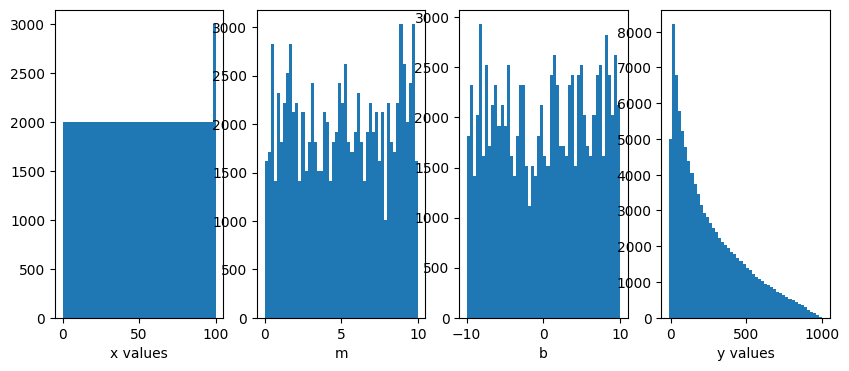

In [12]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [13]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [14]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

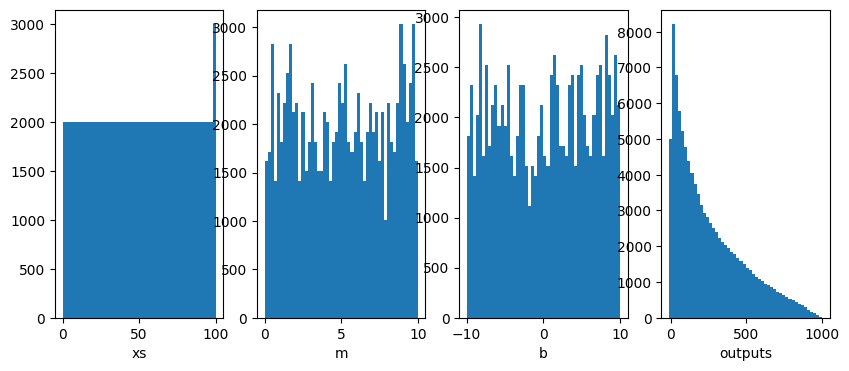

In [15]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


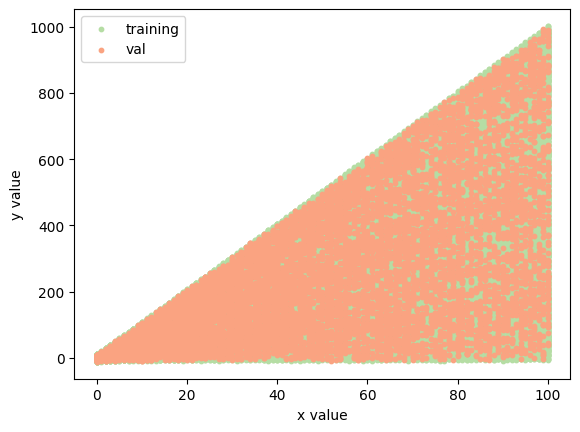

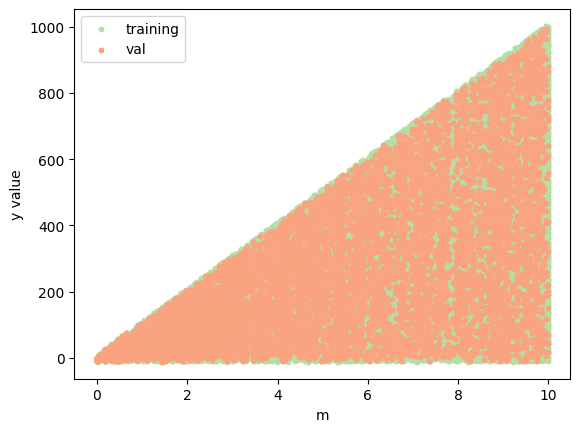

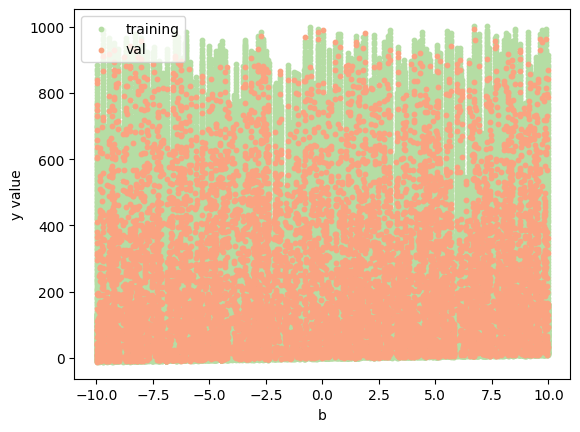

In [16]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [17]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


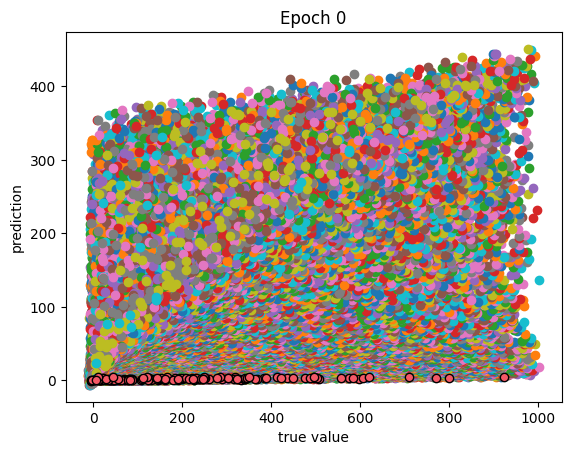

new best loss 7.169040203094482 in epoch 0
epoch 1 0.01
new best loss 5.340308666229248 in epoch 1
epoch 2 0.02
new best loss 4.644159317016602 in epoch 2
epoch 3 0.03
new best loss 4.215553283691406 in epoch 3
epoch 4 0.04
new best loss 3.9861316680908203 in epoch 4
epoch 5 0.05


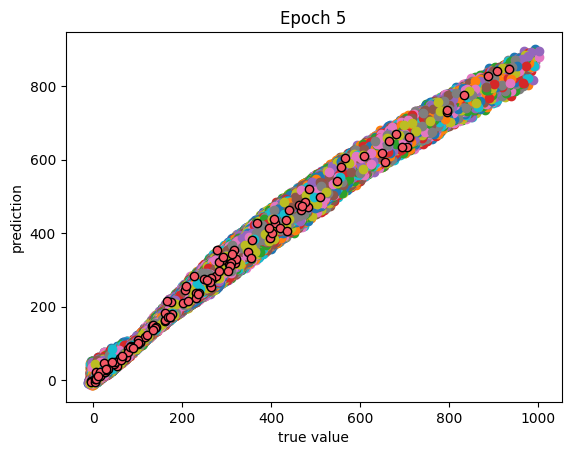

new best loss 3.7072718143463135 in epoch 5
epoch 6 0.06
new best loss 3.508889675140381 in epoch 6
epoch 7 0.07
new best loss 3.190443277359009 in epoch 7
epoch 8 0.08
new best loss 3.039499521255493 in epoch 8
epoch 9 0.09
new best loss 2.795583963394165 in epoch 9
epoch 10 0.1


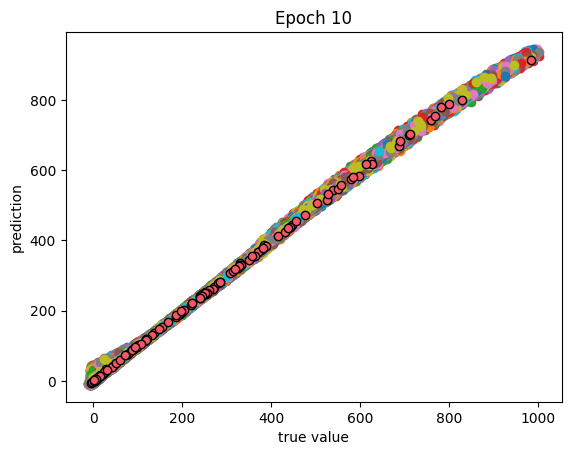

new best loss 2.597954511642456 in epoch 10
epoch 11 0.11
new best loss 2.4806644916534424 in epoch 11
epoch 12 0.12
new best loss 2.4616239070892334 in epoch 12
epoch 13 0.13
new best loss 2.4052987098693848 in epoch 13
epoch 14 0.14
new best loss 2.343027114868164 in epoch 14
epoch 15 0.15


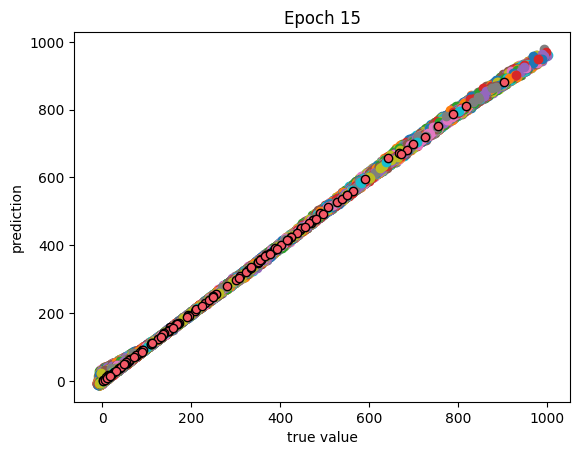

new best loss 2.291621208190918 in epoch 15
epoch 16 0.16
new best loss 2.242344856262207 in epoch 16
epoch 17 0.17
epoch 18 0.18
epoch 19 0.19
new best loss 2.207184314727783 in epoch 19
epoch 20 0.2


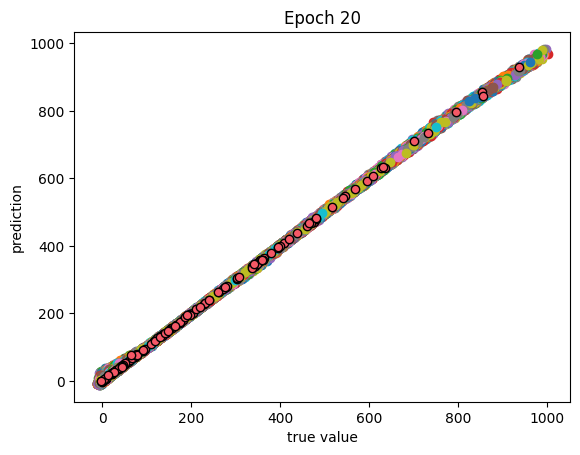

new best loss 2.169902801513672 in epoch 20
epoch 21 0.21
epoch 22 0.22
new best loss 2.0801687240600586 in epoch 22
epoch 23 0.23
epoch 24 0.24
new best loss 2.0671448707580566 in epoch 24
epoch 25 0.25


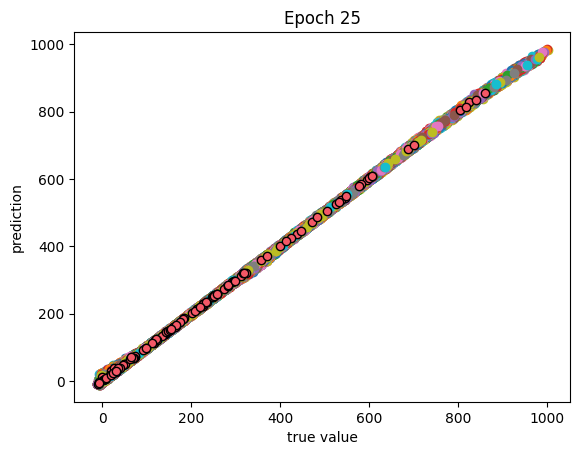

epoch 26 0.26
epoch 27 0.27
epoch 28 0.28
new best loss 2.002411127090454 in epoch 28
epoch 29 0.29
epoch 30 0.3


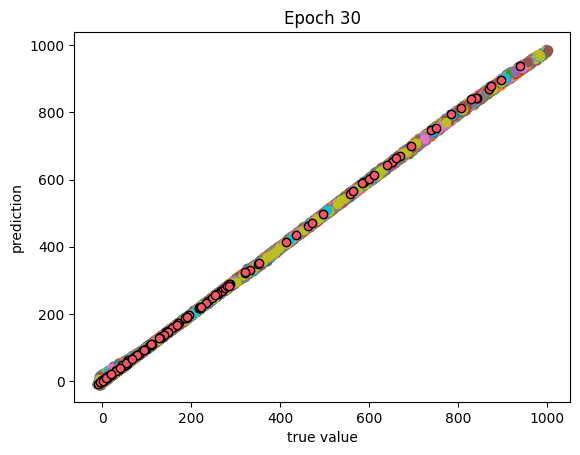

epoch 31 0.31
epoch 32 0.32
new best loss 1.990045428276062 in epoch 32
epoch 33 0.33
new best loss 1.9859440326690674 in epoch 33
epoch 34 0.34
epoch 35 0.35


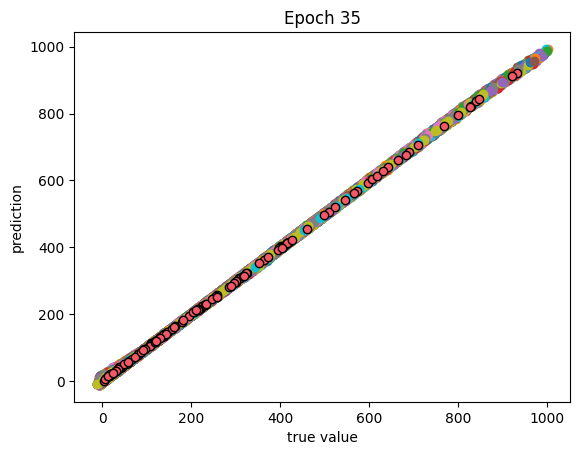

new best loss 1.9783085584640503 in epoch 35
epoch 36 0.36
new best loss 1.940801978111267 in epoch 36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


In [ ]:
# my own training model
DER_type = 'DER'
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_type,
             model_name='DER',
             EPOCHS=100,
             save_checkpoints=False,
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [ ]:
print, epistemic_OG, epistemic_mod 

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()
